# 深層学習　デープニューラルネットワーク

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from collections import defaultdict

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [5]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

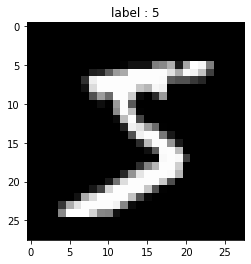

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
#X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0


1.0
0.0


In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64


(60000,)
(60000, 10)
float64


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [10]:
def crossentropy(final_answer, mini_y_train):
    return -np.sum(mini_y_train * np.log(final_answer))/(final_answer.shape[0])

In [11]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose = True):
        
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        self.sigma = 0.01 # ガウス分布の標準偏差
        
        
        
        
        self.verbose = verbose
        pass
    def fit(self, X, y, X_val=None, y_val=None, val=False):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        self.W1 = self.sigma * np.random.randn(X.shape[1], self.n_nodes1)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1,)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2, )
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = self.sigma * np.random.randn(self.n_output, )
        
       
        
        
        #エポック毎の損失を記録
        self.cost = [] 
        self.cost_val = []
        
        self.epoch=20 #何回回すか
        self.alpha = 0.001#学習率
        
        self.hako = []
        self.count = []
        
        #全データ１回分の処理
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
           
                
                
            #バッチ毎の処理

            for mini_X_train, mini_y_train in get_mini_batch:#2400回
                
                #フォアード
                A1 = np.dot(mini_X_train, self.W1) + self.B1
                Z1 = self.tanh(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self.tanh(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                final_answer = self.softmax(A3)
                #バックプロパゲーション
                delta1 = final_answer - mini_y_train
                delta2 = (1 - np.tanh(A2)**2) * (np.dot(delta1,self.W3.T))###(np.dot(delta1,self.W3.T)) = dz
                delta3 = (1 - np.tanh(A1)**2) * (np.dot(delta2,self.W2.T))
                #print(delta3.shape)
                #layer3
                b3grad = delta1
                W3grad = np.dot(Z2.T,delta1)
                #layer2
                b2grad = delta2
                W2grad = np.dot(Z1.T,delta2)
                #layer1
                b1grad = delta3
                W1grad =np.dot(mini_X_train.T,delta3)
                W1grad.shape
                #更新
#                 print(np.mean(b3grad,axis=0).shape)
#                 print(self.B3.shape)
                self.B3 -= self.alpha*np.mean(b3grad,axis=0)
                self.W3 -= self.alpha*W3grad
#                 print(np.mean(b2grad,axis=0).shape)
#                 print(self.B2.shape)
                self.B2 -= self.alpha*np.mean(b2grad,axis=0)
                self.W2 -= self.alpha*W2grad
#                 print(np.mean(b1grad,axis=0).shape)
#                 print(self.B1.shape)
                self.B1 -= self.alpha*np.mean(b1grad,axis=0)
                self.W1 -= self.alpha*W1grad
            
       #フォアード
            A1 = np.dot(X_train, self.W1) + self.B1
            Z1 = self.tanh(A1)
            A2 = np.dot(Z1, self.W2) + self.B2
            Z2 = self.tanh(A2)
            A3 = np.dot(Z2, self.W3) + self.B3
            final_answer = self.softmax(A3)     

                
            self.cost.append(crossentropy(final_answer, y_train))
            
            
            if val:
                A1 = np.dot(X_val, self.W1) + self.B1
                Z1 = self.tanh(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self.tanh(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                final_val_answer = self.softmax(A3)  
                
                self.cost_val.append(crossentropy(final_val_answer, y_val))
                
                
                
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = np.dot(X, self.W1) + self.B1
        Z1 = self.tanh(A1)
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self.tanh(A2)
        A3 = np.dot(Z2, self.W3) + self.B3
        pre_final_answer = self.softmax(A3)
        pre_final_answer_answer = np.argmax(pre_final_answer, axis=1)
        return pre_final_answer_answer
    
    def tanh(self, A):
        return (np.exp(A) - np.exp(-A))/(np.exp(A) + np.exp(-A))
    
    def softmax(self, A3):
        A3 = A3.T
        ue = np.exp(A3)
        shita = np.sum(np.exp(A3), axis = 0)
        return (ue/shita).T
    
    def crossentropy(self, final_answer, mini_y_train):
        return -np.sum(mini_y_train * np.log(final_answer))/(final_answer.shape[0])
    
        return

# 【問題1】全結合層のクラス化

全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

# 【問題2】初期化方法のクラス化

# 【問題3】最適化手法のクラス化

イテレーションごとのフォワード

In [ ]:
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1) #Tanh().forward()
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)

 #フォアード
"""""
A1 = np.dot(mini_X_train, self.W1) + self.B1
Z1 = self.tanh(A1)
A2 = np.dot(Z1, self.W2) + self.B2
Z2 = self.tanh(A2)
A3 = np.dot(Z2, self.W3) + self.B3
final_answer(Z3) = self.softmax(A3)
""""""

In [ ]:
イテレーションごとのバックワード

In [ ]:
dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている???????
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

""""
バックプロパゲーション
delta1 = final_answer - mini_y_train
delta2 = (1 - np.tanh(A2)**2) * (np.dot(delta1,self.W3.T))
delta3 = (1 - np.tanh(A1)**2) * (np.dot(delta2,self.W2.T))
""""""
#layer3
b3grad = delta1
W3grad = np.dot(Z2.T,delta1)
#layer2
b2grad = delta2
W2grad = np.dot(Z1.T,delta2)
#layer1
b1grad = delta3
W1grad =np.dot(mini_X_train.T,delta3)
W1grad.shape

In [13]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B =  initializer.B(n_nodes2)
        """"
        self.W1 = self.sigma * np.random.randn(X.shape[1], self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1,)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2, )
        self.B3 = self.sigma * np.random.randn(self.n_output, )
        """""
        pass
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.Z = Z.copy()
        
        return np.dot(Z, self.W) + self.B #output=A
        
        """""
        A1 = np.dot(mini_X_train, self.W1) + self.B1
        Z1 = self.tanh(A1)
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self.tanh(A2) 
        A3 = np.dot(Z2, self.W3) + self.B3
        final_answer = self.softmax(A3)
        """

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dB = dA #b3grad = delta1=dA
        #print(self.Z.shape)
        #print(dA.shape)
        self.dW = np.dot(self.Z.T,dA) #np.dot(___Z2___, dA)shapedW?? = np.dot(self.Z,dA) のshape確認
        
        dZ = np.dot(dA, self.W.T)#(np.dot(delta1,self.W3.T)
        
        # 更新
        self = self.optimizer.update(self) #??????
        return dZ
    

# 問題4】活性化関数のクラス化

活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [14]:
class Tanh:
    def __init__(self):
        self.A = None
        
    def forward(self, A):
        self.A = A
        return (np.exp(self.A) - np.exp(-self.A))/(np.exp(self.A) + np.exp(-self.A))
    
    def backward(self, dZ):
        return dZ*(1 - self.forward(self.A)**2)

In [15]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2 ):
        return self.sigma*np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return  self.sigma * np.random.randn(n_nodes2)
      

In [16]:
class Softmax_with_crossentropyloss():
    def __init__(self):
        pass
        
    def forward(self,A):
        A = A.T
        ue = np.exp(A)
        shita = np.sum(np.exp(A), axis = 0)
        self.Z_final = (ue/shita).T
        return self.Z_final
    
    def backward(self,y):
        return self.Z_final - y#正解ラベル
    

In [17]:
class SGD:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def update(self, layer):#FCのインスタンス入る self? layer.W→self.W?
        layer.W = layer.W - self.alpha * layer.dW
        #layer.B = layer.B - self.alpha * layer.dB.mean(axis=1)
        layer.B = layer.B - self.alpha *np.mean( layer.dB,axis=0)
        return layer

# 【問題5】ReLUクラスの作成

現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$

x
 : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための 
x
 に関する 
f
(
x
)
 の微分は以下のようになります。

$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$

数学的には微分可能ではないですが、 
x
=
0
 のとき 
0
 とすることで対応しています。


フォワード時の 
x
 の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [18]:
class ReLU:
    def __init__(self):
        pass
    def forward(self, X):
        self.mask = np.where(X>0, 1, 0)
        
        return np.maximum(0, X)
    
    def backward(self, X):
        X = X*self.mask
        return X
    

In [19]:
class reluuuuuu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <=0)
        out = x.copy()
        out[self.mask]= 0
        
        return out

    def backward(self, dout):
        dout[self.mask]= 0
        dx = dout
        
        return dx

In [ ]:
ooo = np.arange(10).reshape([5,2])
ooo

In [ ]:
reluu = ReLU()
reluu.forward(ooo)
reluu.backward(ooo)

In [ ]:
shita= np.random.randn(3, 3)
shita

In [ ]:
reluoo = reluuuuuu()
reluoo.forward(shita)

In [ ]:
mask = (shita <=0)

In [ ]:
shita[mask]=0

# 【問題6】重みの初期値

シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。

### Xavierの初期値

Xavierの初期値における標準偏差 
σ
 は次の式で求められます。

$
\sigma = \frac{1}{\sqrt{n}}
$

In [183]:
# Xavierをインスタンス化するときはXavier(self.n_nodes)とする

class Xavier:
    def __init__(self, n_nodes1):
        self.n_nodes1= n_nodes1
        self.sigma = 1/np.sqrt(self.n_nodes1)
               
    def W(self, n_nodes1, n_nodes2):
        return self.sigma*np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return  self.sigma * np.random.randn(n_nodes2)

### Heの初期値

Heの初期値における標準偏差 
σ
 は次の式で求められます。

$
\sigma = \sqrt{\frac{2}{n}}
$

In [162]:
# Heをインスタンス化するときはXavier(self.n_nodes)とする
class He:
    def __init__(self, n_nodes1):
        self.n_nodes1= n_nodes1
        self.sigma = np.sqrt(2/self.n_nodes1)
        
        
    def W(self, n_nodes1, n_nodes2):
        return self.sigma*np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return  self.sigma * np.random.randn(n_nodes2)

# 【問題7】最適化手法

$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\<br/>W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$

In [153]:
class AdaGrad:
    def __init__(self, alpha):
        self.alpha = alpha
        self.h_W = 0
        self.h_B = 0
        
    def update(self, layer):#FCのインスタンス入る self? layer.W→self.W?
        self.h_W = self.h_W + (layer.dW* layer.dW)
        self.h_B = self.h_B + (np.mean(layer.dB,axis=0)* np.mean(layer.dB,axis=0))
        layer.W = layer.W - (self.alpha*np.sqrt(1/self.h_W)) * layer.dW
        #layer.B = layer.B - self.alpha * layer.dB.mean(axis=1)
        layer.B = layer.B - (self.alpha*np.sqrt(1/self.h_B)) *np.mean(layer.dB,axis=0)
        #print(layer.B.shape)
        return layer
    

# 【問題8】クラスの完成

In [132]:
class ScrachDeepNeuralNetworkRegressor():
    
    def __init__(self, n_epochs, batch, alpha = np.exp(-7), sigma = 0.01, n_nodes1 = 400, n_nodes2 = 200, n_output = 10):
        self.n_epochs = n_epochs
        self.batch = batch
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.loss = []#np.zeros(n_epochs)
        self.val_loss = []#np.zeros(n_epochs)
        self.alpha = alpha
        self.sigma = sigma
        
    def fit(self, X, y, X_val=None, y_val=None, val=False):
        #y = y[:, np.newaxis]
        
       # y_val = y_val[:,np.newaxis]
        self.X = X
        self.y = y
        
        self.n_features = self.X.shape[1]
        train_minibatch = GetMiniBatch(self.X, y, self.batch)
        test_minibatch = GetMiniBatch(X_val, y_val, self.batch)
        
        optimizer = SGD(self.alpha)
        #optimizer1 = AdaGrad(self.alpha)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        #self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer1)
        #self.activation1 = Tanh()
        self.activation1 = ReLU()
        #optimizer2 = AdaGrad(self.alpha)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        #self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer2)
        #self.activation2 = Tanh()
        self.activation2 = ReLU()
        #optimizer3 = AdaGrad(self.alpha)
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        #self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        self.activation3 = Softmax_with_crossentropyloss()
        
        for epoch in range(self.n_epochs):
            for mini_X, mini_y in train_minibatch:
                X = mini_X
                y = mini_y#[:,np.newaxis] ############
                #フォワード
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1) #Tanh().forward()
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3 = self.activation3.backward(y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            
            print(self.X.shape)
            A4 = self.FC1.forward(self.X)
            print(A4.shape)
            Z4 = self.activation1.forward(A4)
            A5 = self.FC2.forward(Z4)
            Z5 = self.activation2.forward(A5)
            A6 = self.FC3.forward(Z5)
            Z6 = self.activation3.forward(A6)
            print(Z6.shape)
            print(self.y.shape)
            print(self.crossentropy(Z6, self.y))
            self.loss.append(self.crossentropy(Z6, self.y))####?
            
#             print(self.X.shape)
#             A1 = self.FC1.forward(self.X)
#             print(A1)
#             Z1 = self.activation1.forward(A1)
#             A2 = self.FC2.forward(Z1)
#             Z2 = self.activation2.forward(A2)
#             A3 = self.FC3.forward(Z2)
#             Z3 = self.activation3.forward(A3)
#             print(Z3)
#             print(y)
#             print(self.crossentropy(Z3, y))
#             self.loss.append(self.crossentropy(Z3, y))####?
            
            
            if val:
                A_val1 = self.FC1.forward(X_val)
                Z_val1 = self.activation1.forward(A_val1)
                A_val3 = self.FC2.forward(Z_val1)
                Z_val2 = self.activation2.forward(A_val3)
                A_val3 = self.FC3.forward(Z_val2)
                Z_val3 = self.activation3.forward(A_val3)

                self.val_loss.append(self.crossentropy(Z_val3, y_val))
            
                
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1) #X,self.X
        #print(Z1.shape)
        A2 = self.FC2.forward(Z1)
                #print(A2.shape)
        Z2 = self.activation2.forward(A2)
                #print(Z2.shape)
        A3 = self.FC3.forward(Z2)
                #print(A3.shape)
        pre_final_answer = self.activation3.forward(A3)
        pre_final_answer_answer = np.argmax(pre_final_answer, axis=1)
        return pre_final_answer_answer
    
    def crossentropy(self, final_answer, y):
        return -np.sum(y * np.log(final_answer))/(final_answer.shape[0])
        
                
        
                
        return
            
                
                
                
        

In [133]:
dnnr = ScrachDeepNeuralNetworkRegressor(n_epochs=15, batch=20)

In [134]:
dnnr.fit(X_train, y_train, X_val, y_val, val=True)

(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.5585617583392231
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.32817041845886796
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.2398582959773998
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.17905904427050254
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.14168907383741053
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.11560717536778242
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.09692549525374275
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.08228833610274441
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.07049009658763745
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.0610579980118431
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.05324085897370648
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.04652248147116744
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.04100598938251051
(48000, 784)
(48000, 400)
(48000, 10)
(48000, 10)
0.03611720561813446
(48000, 784)
(48000, 40

In [135]:
dnnr.FC1.B.shape

(400,)

In [136]:
predict_y = dnnr.predict(X_val)


In [137]:
predict_y

array([8, 1, 4, ..., 6, 0, 5])

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
predict_box = np.zeros((len(predict_y),10),dtype=int)
predict_box.shape

(12000, 10)

In [140]:
for v in range(len(predict_y)):
    predict_box[v,predict_y[v]] = 1

In [141]:
predict_box

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [142]:
###Accuracy###
accuracy_score(y_val, predict_box)

0.9755

# 【問題9】学習と推定

層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [143]:
dnnr.loss

[0.5585617583392231,
 0.32817041845886796,
 0.2398582959773998,
 0.17905904427050254,
 0.14168907383741053,
 0.11560717536778242,
 0.09692549525374275,
 0.08228833610274441,
 0.07049009658763745,
 0.0610579980118431,
 0.05324085897370648,
 0.04652248147116744,
 0.04100598938251051,
 0.03611720561813446,
 0.03209396226577688]

In [144]:
dnnr.val_loss

[0.5603941482520077,
 0.332011099583898,
 0.24853984913202035,
 0.19334336705915586,
 0.16098326427426543,
 0.13911149999612635,
 0.12397388452544131,
 0.1130578946905548,
 0.10501375218272259,
 0.09942885495296838,
 0.09526663739625693,
 0.09236381339711448,
 0.09048471093014884,
 0.08914225304408074,
 0.08844310143929006]

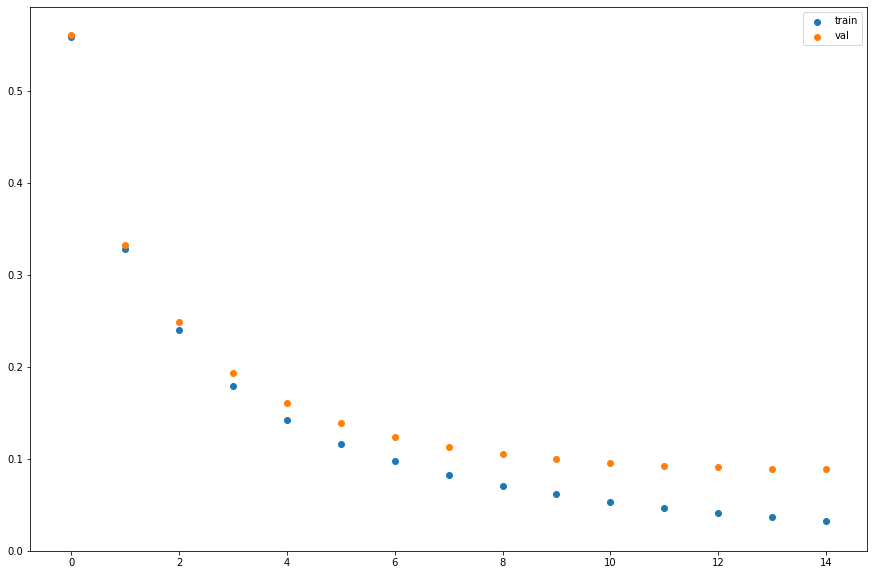

In [145]:
import matplotlib.pyplot as plt
x=list(range(dnnr.n_epochs))
plt.figure(figsize=(15,10))
plt.scatter(x,dnnr.loss, label='train')
plt.scatter(x, dnnr.val_loss, label='val')
plt.legend()
plt.show()

In [193]:
class ScrachDeepNeuralNetworkRegressor2():
    
    def __init__(self, n_epochs, batch, alpha = np.exp(-7), sigma = 0.01, n_nodes1 = 400, n_nodes2 = 200, n_output = 10):
        self.n_epochs = n_epochs
        self.batch = batch
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.loss = []#np.zeros(n_epochs)
        self.val_loss = []#np.zeros(n_epochs)
        self.alpha = alpha
        self.sigma = sigma
        
    def fit(self, X, y, X_val=None, y_val=None, val=False):
        #y = y[:, np.newaxis]
        
       # y_val = y_val[:,np.newaxis]
        self.X = X
        self.y = y
        
        self.n_features = self.X.shape[1]
        train_minibatch = GetMiniBatch(self.X, y, self.batch)
        test_minibatch = GetMiniBatch(X_val, y_val, self.batch)
        
        optimizer = SGD(self.alpha)
        #optimizer1 = AdaGrad(self.alpha)
        self.FC1 = FC(self.n_features, self.n_nodes1, Xavier(self.n_nodes1), optimizer)
        #self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer1)
        self.activation1 = Tanh()
        #self.activation1 = ReLU()
        #optimizer2 = AdaGrad(self.alpha)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier(self.n_nodes1), optimizer)
        #self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer2)
        self.activation2 = Tanh()
        #self.activation2 = ReLU()
        #optimizer3 = AdaGrad(self.alpha)
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(self.n_nodes1), optimizer)
        #self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        self.activation3 = Softmax_with_crossentropyloss()
        
        for epoch in range(self.n_epochs):
            for mini_X, mini_y in train_minibatch:
                X = mini_X
                y = mini_y#[:,np.newaxis] ############
                #フォワード
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1) #Tanh().forward()
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3 = self.activation3.backward(y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
            

            A4 = self.FC1.forward(self.X)
            Z4 = self.activation1.forward(A4)
            A5 = self.FC2.forward(Z4)
            Z5 = self.activation2.forward(A5)
            A6 = self.FC3.forward(Z5)
            Z6 = self.activation3.forward(A6)

            self.loss.append(self.crossentropy(Z6, self.y))

            
            if val:
                A_val1 = self.FC1.forward(X_val)
                Z_val1 = self.activation1.forward(A_val1)
                A_val3 = self.FC2.forward(Z_val1)
                Z_val2 = self.activation2.forward(A_val3)
                A_val3 = self.FC3.forward(Z_val2)
                Z_val3 = self.activation3.forward(A_val3)

                self.val_loss.append(self.crossentropy(Z_val3, y_val))
            
                
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1) #X,self.X
        #print(Z1.shape)
        A2 = self.FC2.forward(Z1)
                #print(A2.shape)
        Z2 = self.activation2.forward(A2)
                #print(Z2.shape)
        A3 = self.FC3.forward(Z2)
                #print(A3.shape)
        pre_final_answer = self.activation3.forward(A3)
        pre_final_answer_answer = np.argmax(pre_final_answer, axis=1)
        return pre_final_answer_answer
    
    def crossentropy(self, final_answer, y):
        return -np.sum(y * np.log(final_answer))/(final_answer.shape[0])
        
                
        
                
        return
            
                
                
                
        

In [194]:
snnr_xavier = ScrachDeepNeuralNetworkRegressor2(n_epochs=15, batch=20)

In [195]:
snnr_xavier.fit(X_train, y_train, X_val, y_val, val=True)

In [196]:
predict_xavier_y = snnr_xavier.predict(X_val)

In [198]:
predict_xavierbox = np.zeros((len(predict_xavier_y),10),dtype=int)
predict_xavierbox

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [199]:
for j in range(len(predict_xavier_y)):
    predict_xavierbox[j,predict_xavier_y [j]] = 1

In [200]:
predict_xavierbox

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [202]:
###Accuracy###
accuracy_score(y_val, predict_xavierbox)

0.9726666666666667

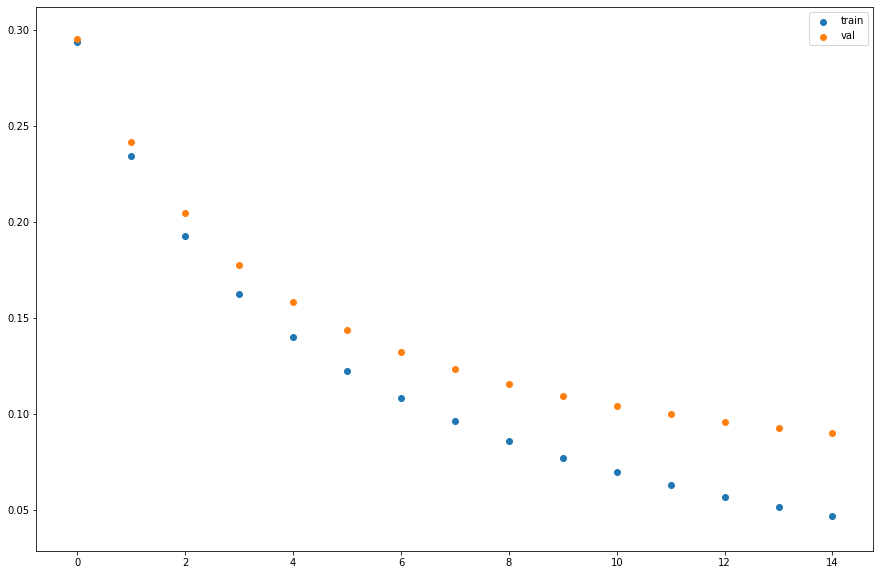

In [203]:
x2=list(range(snnr_xavier.n_epochs))
plt.figure(figsize=(15,10))
plt.scatter(x2,snnr_xavier.loss, label='train')
plt.scatter(x2, snnr_xavier.val_loss, label='val')
plt.legend()
plt.show()